# Training an Object Detector with IceVision

In [1]:
%matplotlib inline

In [2]:
# # Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
# !wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# # Choose your installation target: cuda11 or cuda10 or cpu
# !bash icevision_install.sh cuda11 master

In [3]:
from icevision.all import *
from fastai.callback.wandb import *
from fastai.callback.tracker import SaveModelCallback

/home/ubuntu/.conda/envs/icevision/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /home/ubuntu/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17
INFO     - The mmseg config folder already exists. No need to downloaded it. Path : /home/ubuntu/.icevision/mmsegmentation_configs/mmsegmentation_configs-0.17.0/configs | icevision.models.mmseg.download_configs:download_mmseg_configs:19


In [4]:
annotations_filepath = "../data/annotations/2022-10-04_combined_n-224_coco.json"
img_dir = "../data/images/"

# Create the parser
parser = parsers.COCOBBoxParser(annotations_filepath = annotations_filepath, 
                                img_dir = img_dir)

In [5]:
# Parse annotations to create records
train_records, valid_records = parser.parse()
parser.class_map

100%|██████████| 231/231 [00:00<00:00, 1821.37it/s]
INFO     - Autofixing records | icevision.parsers.parser:parse:122
100%|██████████| 223/223 [00:00<00:00, 19884.13it/s]


<ClassMap: {'background': 0, 'Slate': 1}>

In [6]:
# Transforms
# size is set like so because EfficientDet requires its inputs to be divisible by 128
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [7]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

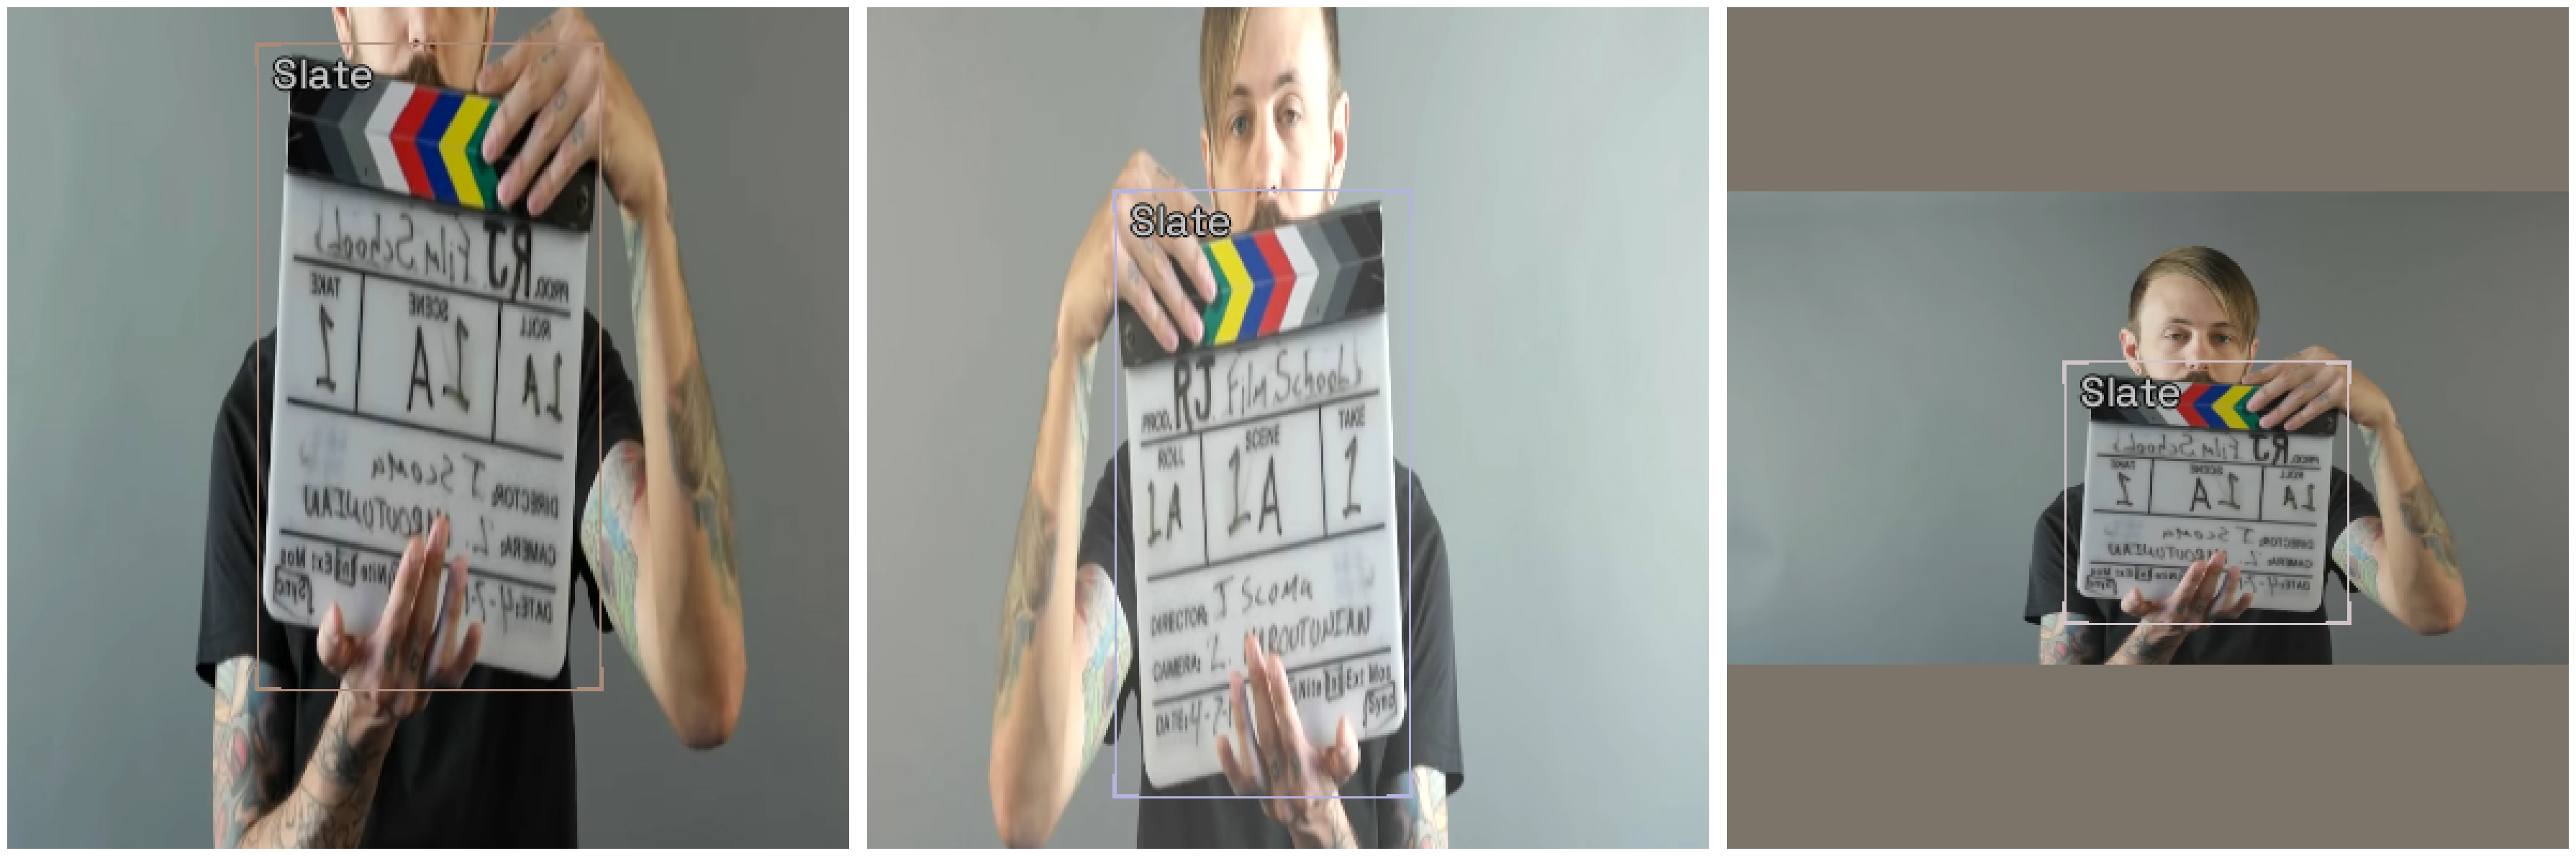

In [8]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

In [9]:
# Just change the value of selection to try another model

selection = 12

extra_args = {}

if selection == 0:
  model_type = models.mmdet.vfnet
  backbone = model_type.backbones.resnet50_fpn_mstrain_2x

if selection == 1:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x
  # extra_args['cfg_options'] = { 
  #   'model.bbox_head.loss_bbox.loss_weight': 2,
  #   'model.bbox_head.loss_cls.loss_weight': 0.8,
  #    }

if selection == 2:
  model_type = models.mmdet.faster_rcnn
  backbone = model_type.backbones.resnet101_fpn_2x
  # extra_args['cfg_options'] = { 
  #   'model.roi_head.bbox_head.loss_bbox.loss_weight': 2,
  #   'model.roi_head.bbox_head.loss_cls.loss_weight': 0.8,
  #    }

if selection == 3:
  model_type = models.mmdet.ssd
  backbone = model_type.backbones.ssd300

if selection == 4:
  model_type = models.mmdet.yolox
  backbone = model_type.backbones.yolox_s_8x8

if selection == 5:
  model_type = models.mmdet.yolof
  backbone = model_type.backbones.yolof_r50_c5_8x8_1x_coco

if selection == 6:
  model_type = models.mmdet.detr
  backbone = model_type.backbones.r50_8x2_150e_coco

if selection == 7:
  model_type = models.mmdet.deformable_detr
  backbone = model_type.backbones.twostage_refine_r50_16x2_50e_coco

if selection == 8:
  model_type = models.mmdet.fsaf
  backbone = model_type.backbones.x101_64x4d_fpn_1x_coco

if selection == 9:
  model_type = models.mmdet.sabl
  backbone = model_type.backbones.r101_fpn_gn_2x_ms_640_800_coco

if selection == 10:
  model_type = models.mmdet.centripetalnet
  backbone = model_type.backbones.hourglass104_mstest_16x6_210e_coco

elif selection == 11:
  # The Retinanet model is also implemented in the torchvision library
  model_type = models.torchvision.retinanet
  backbone = model_type.backbones.resnet50_fpn

elif selection == 12:
  model_type = models.ross.efficientdet
  backbone = model_type.backbones.tf_d2
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = image_size

elif selection == 13:
  model_type = models.ultralytics.yolov5
  backbone = model_type.backbones.small
  # The yolov5 model requires an img_size parameter
  extra_args['img_size'] = image_size

model_type, backbone, extra_args

(<module 'icevision.models.ross.efficientdet' from '/home/ubuntu/.conda/envs/icevision/lib/python3.9/site-packages/icevision/models/ross/efficientdet/__init__.py'>,
 {'img_size': 384})

In [10]:
backbone.__dict__

{'model_name': 'tf_efficientdet_d2'}

In [11]:
# Instantiate the model
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

Downloading: "https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d2_43-8107aa99.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/tf_efficientdet_d2_43-8107aa99.pth


In [12]:
model.to('cuda')

device=next(model.parameters()).device
device

device(type='cuda', index=0)

In [13]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

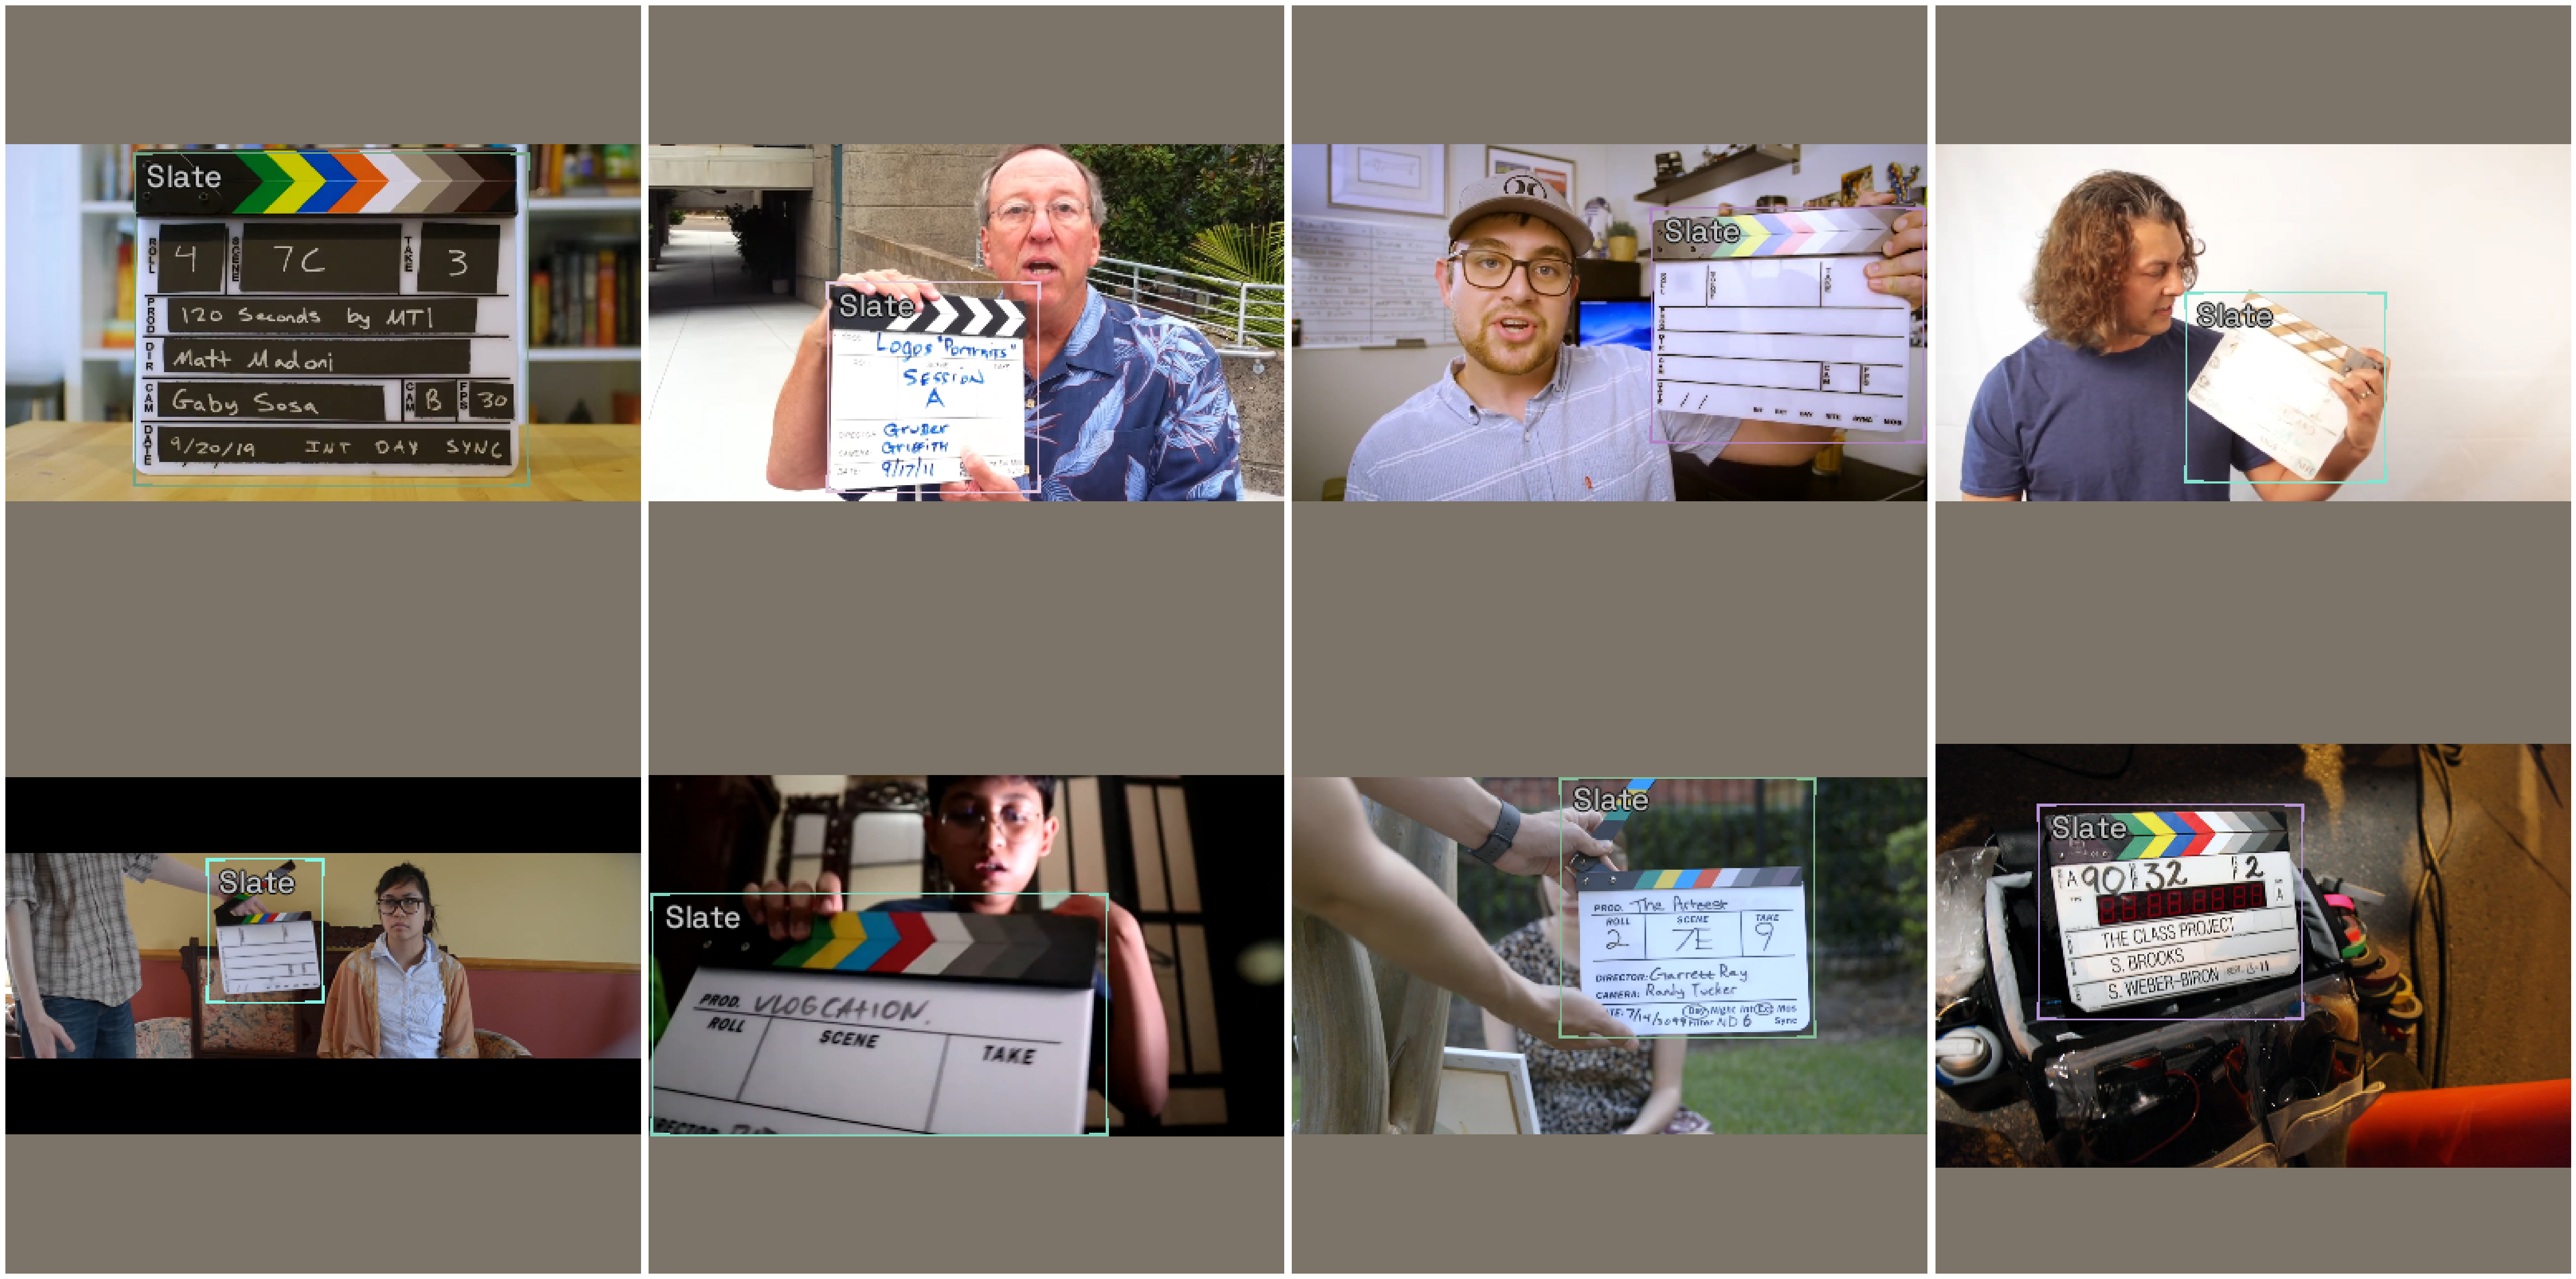

In [14]:
# show batch
model_type.show_batch(first(valid_dl), ncols=4)

## Metrics

The fastai and pytorch lightning engines collect metrics to track progress during training. IceVision provides metric classes that work across the engines and libraries.

The same metrics can be used for both fastai and pytorch lightning.

In [15]:
from icevision.imports import *
from icevision.utils import *
from icevision.data import *
from icevision.metrics.metric import *


class COCOMetricType(Enum):
    """Available options for `COCOMetric`."""

    bbox = "bbox"
    mask = "segm"
    keypoint = "keypoints"


class COCOMetric(Metric):
    """Wrapper around [cocoapi evaluator](https://github.com/cocodataset/cocoapi)
    Calculates average precision.
    # Arguments
        metric_type: Dependent on the task you're solving.
        print_summary: If `True`, prints a table with statistics.
        show_pbar: If `True` shows pbar when preparing the data for evaluation.
    """

    def __init__(
        self,
        metric_type: COCOMetricType = COCOMetricType.bbox,
        iou_thresholds: Optional[Sequence[float]] = None,
        print_summary: bool = False,
        show_pbar: bool = False,
    ):
        self.metric_type = metric_type
        self.iou_thresholds = iou_thresholds
        self.print_summary = print_summary
        self.show_pbar = show_pbar
        self._records, self._preds = [], []

    def _reset(self):
        self._records.clear()
        self._preds.clear()

    def accumulate(self, preds):
        for pred in preds:
            self._records.append(pred.ground_truth)
            self._preds.append(pred.pred)

    def finalize(self) -> Dict[str, float]:
        with CaptureStdout():
            coco_eval = create_coco_eval(
                records=self._records,
                preds=self._preds,
                metric_type=self.metric_type.value,
                iou_thresholds=self.iou_thresholds,
                show_pbar=self.show_pbar,
            )
            coco_eval.evaluate()
            coco_eval.accumulate()

        with CaptureStdout(propagate_stdout=self.print_summary):
            coco_eval.summarize()

        stats = coco_eval.stats
        logs = {
            "AP (IoU=0.50:0.95) area=all": stats[0],
            "AP (IoU=0.50) area=all": stats[1],
            "AP (IoU=0.75) area=all": stats[2],
            "AP (IoU=0.50:0.95) area=small": stats[3],
            "AP (IoU=0.50:0.95) area=medium": stats[4],
            "AP (IoU=0.50:0.95) area=large": stats[5],
            "AR (IoU=0.50:0.95) area=all maxDets=1": stats[6],
            "AR (IoU=0.50:0.95) area=all maxDets=10": stats[7],
            "AR (IoU=0.50:0.95) area=all maxDets=100": stats[8],
            "AR (IoU=0.50:0.95) area=small maxDets=100": stats[9],
            "AR (IoU=0.50:0.95) area=medium maxDets=100": stats[10],
            "AR (IoU=0.50:0.95) area=large maxDets=100": stats[11],
        }

        self._reset()
        return logs

In [16]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

## Training

IceVision is an agnostic framework meaning it can be plugged into other DL learning engines such as [fastai2](https://github.com/fastai/fastai2), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning).  


### Training using fastai

In [17]:
# Instantiate wandb
wandb.init(project="Film-clapper-detector", 
           name="2022-10-07_efficientDet_n-224_r-384", 
           entity="boscacci-farid",
           reinit=True)

wandb: Currently logged in as: cinemarob1 (boscacci-farid). Use `wandb login --relogin` to force relogin


In [18]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, 
                                  metrics=[COCOMetric(metric_type=COCOMetricType.bbox)], 
                                  cbs=[WandbCallback(), SaveModelCallback()])

SuggestedLRs(valley=0.0008317637839354575)

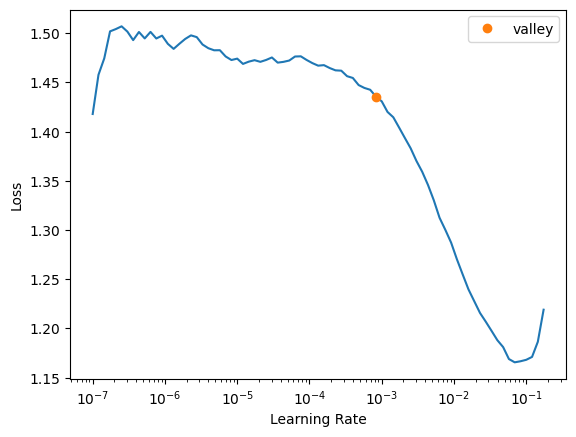

In [19]:
learn.lr_find()

# For Sparse-RCNN, use lower `end_lr`
# learn.lr_find(end_lr=0.005)

In [20]:
learn.fine_tune(20, 0.00158, freeze_epochs=1)

Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


epoch,train_loss,valid_loss,COCOMetric,time
0,1.288568,1.198473,0.133869,00:16


/home/ubuntu/.conda/envs/icevision/lib/python3.9/site-packages/effdet/bench.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices_all = cls_topk_indices_all // num_classes


Better model found at epoch 0 with valid_loss value: 1.1984728574752808.
Could not gather input dimensions


epoch,train_loss,valid_loss,COCOMetric,time
0,0.876207,1.057363,0.303931,00:10
1,0.773413,0.902030,0.440549,00:09
2,0.679236,0.755032,0.532266,00:09
3,0.615518,0.643471,0.570418,00:09
4,0.542726,0.515407,0.606722,00:10
5,0.488988,0.436349,0.630407,00:09
6,0.450181,0.353423,0.662177,00:09
7,0.424856,0.309331,0.738370,00:10
8,0.392189,0.325424,0.712974,00:09
9,0.369494,0.284940,0.757907,00:09


Better model found at epoch 0 with valid_loss value: 1.0573631525039673.
Better model found at epoch 1 with valid_loss value: 0.9020304083824158.
Better model found at epoch 2 with valid_loss value: 0.7550322413444519.
Better model found at epoch 3 with valid_loss value: 0.6434713006019592.
Better model found at epoch 4 with valid_loss value: 0.5154074430465698.
Better model found at epoch 5 with valid_loss value: 0.43634897470474243.
Better model found at epoch 6 with valid_loss value: 0.353423148393631.
Better model found at epoch 7 with valid_loss value: 0.3093305826187134.
Better model found at epoch 9 with valid_loss value: 0.28493958711624146.
Better model found at epoch 10 with valid_loss value: 0.2832085192203522.
Better model found at epoch 11 with valid_loss value: 0.27946820855140686.
Better model found at epoch 14 with valid_loss value: 0.26723983883857727.
Better model found at epoch 19 with valid_loss value: 0.2672227919101715.


## Using the model - inference and showing results

The first step in reviewing the model is to show results from the validation dataset. This is easy to do with the `show_results` function.

In [21]:
%matplotlib inline

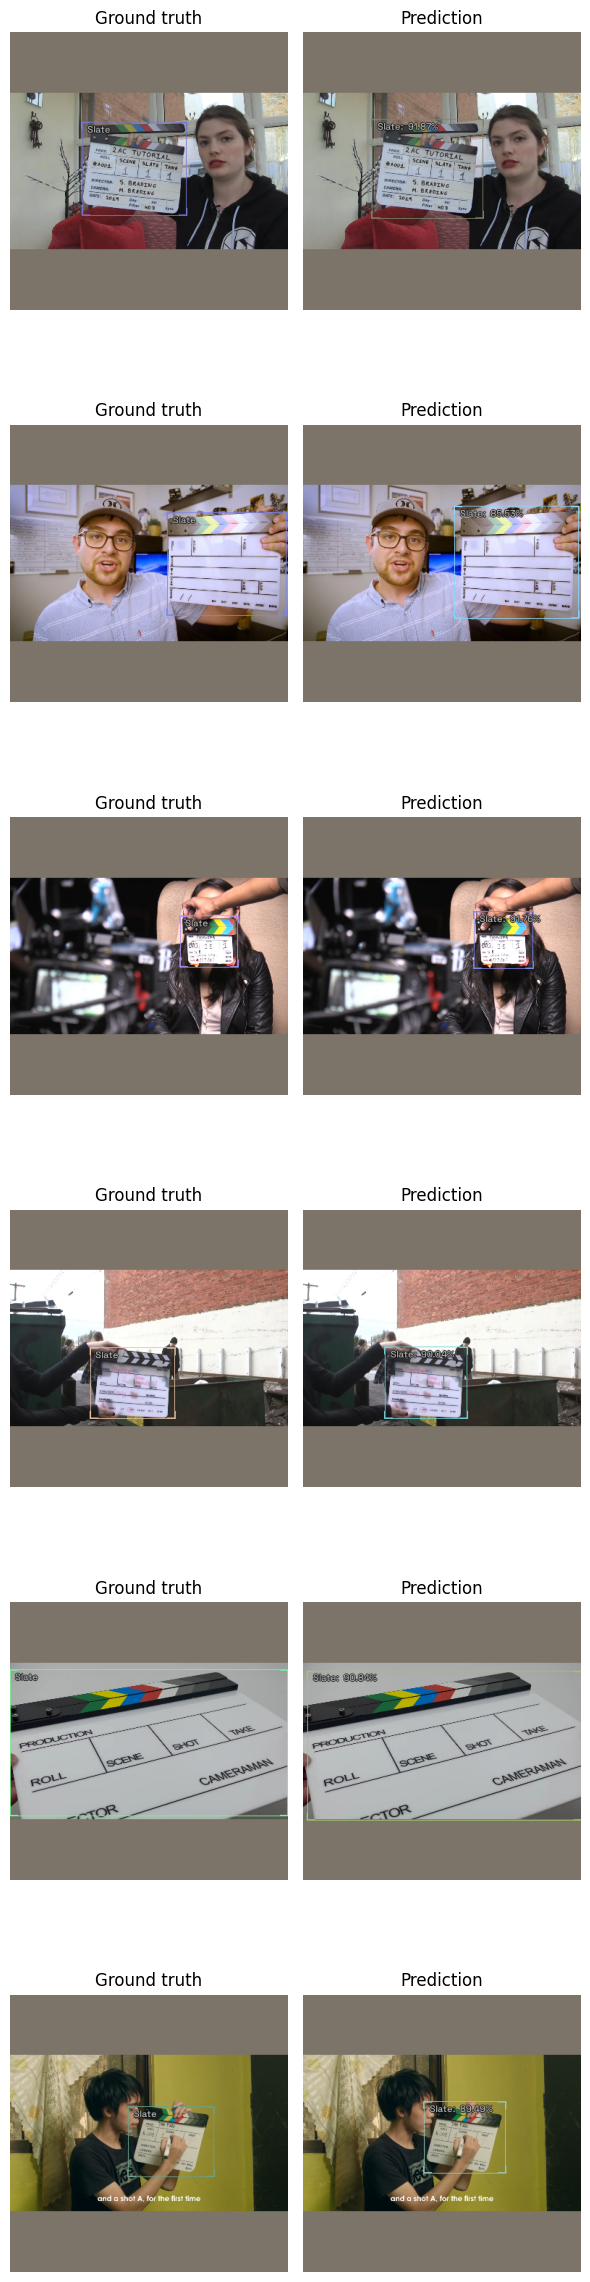

In [22]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

In [23]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

100%|██████████| 12/12 [00:02<00:00,  4.81it/s]


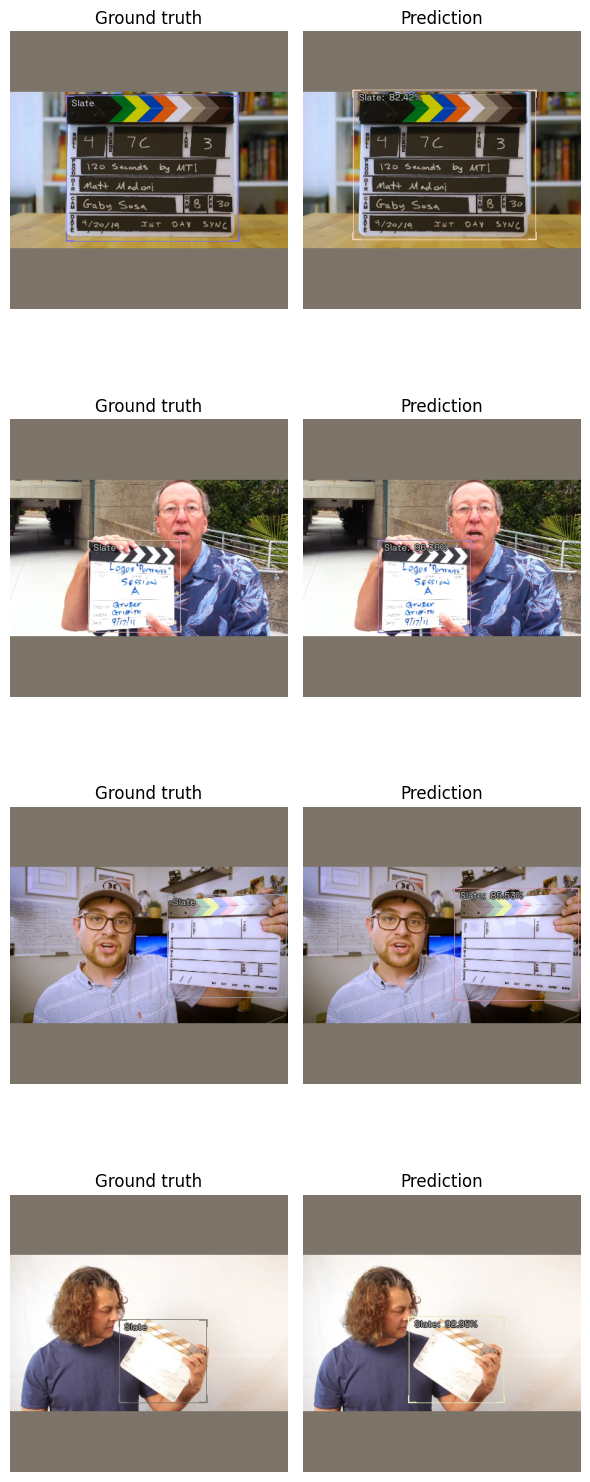

In [24]:
show_preds(preds=preds[:4])

In [25]:
# Create wandb_images for each prediction
wandb_images = wandb_img_preds(preds, add_ground_truth=True) 

# Log the wandb_images to wandb
wandb.log({"Predicted images": wandb_images})

wandb.join()

COCOMetric,▁▃▄▅▆▆▆▇█▇███▇▇██████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▂█▂▂▂▃▃▄▄▅▅▅▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁
lr_2,▂█▂▂▂▃▃▄▄▅▅▅▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁
mom_0,█▃██▇▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▄▄▄▅▅▆▆▆▇▇▇▇████
mom_1,█▃██▇▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▄▄▄▅▅▆▆▆▇▇▇▇████
mom_2,█▃██▇▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▄▄▄▅▅▆▆▆▇▇▇▇████


# Export Model

In [26]:
from icevision.models.checkpoint import *

In [27]:
model_type

<module 'icevision.models.ross.efficientdet' from '/home/ubuntu/.conda/envs/icevision/lib/python3.9/site-packages/icevision/models/ross/efficientdet/__init__.py'>

In [ ]:
model_name = "mmdet.faster_rcnn"
model_name

In [ ]:
backbone.__dict__

In [ ]:
backbone_name = "resnet101_fpn_2x"
backbone_name

In [ ]:
image_size

In [ ]:
fname = '../models/2022-10-07_resnet_slates_224.pth'

save_icevision_checkpoint(model,
                        model_name=model_name, 
                        backbone_name=backbone_name,
                        img_size=image_size,
                        classes=parser.class_map.get_classes(),
                        filename=fname,
                        meta={'icevision_version': '0.12.0'})